In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [52]:
df = pd.read_csv('./dataset/temp data/temp.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns=['기온', '습도', 'co2', 'label']
df

,기온,습도,co2,label
0,-11.3,47.0,3702,1
1,-10.2,44.0,2697,1
2,-10.1,42.0,5792,1
3,-10.2,42.0,4437,1
4,-10.6,44.0,6934,1
...,...,...,...,...
508982,17.6,84.0,3526,1
508983,17.6,86.0,6355,1
508984,17.5,85.0,2503,1
508985,17.7,81.0,568,1


In [53]:
df = df.drop(df.loc[df['기온'] < -20].index)

In [54]:
df.info

<bound method DataFrame.info of           기온    습도   co2  label
0      -11.3  47.0  3702      1
1      -10.2  44.0  2697      1
2      -10.1  42.0  5792      1
3      -10.2  42.0  4437      1
4      -10.6  44.0  6934      1
...      ...   ...   ...    ...
508982  17.6  84.0  3526      1
508983  17.6  86.0  6355      1
508984  17.5  85.0  2503      1
508985  17.7  81.0   568      1
508986  17.8  84.0  4146      1

[507992 rows x 4 columns]>

In [55]:
df.describe()

,기온,습도,co2,label
count,507992.000000,507992.000000,507992.000000,507992.000000
mean,8.282168,55.996262,3500.175784,0.835348
std,8.779559,19.168782,2021.490863,0.370867
min,-19.900000,6.000000,0.000000,0.000000
25%,0.900000,42.000000,1746.000000,1.000000
50%,8.800000,55.000000,3501.000000,1.000000
75%,15.200000,70.000000,5254.000000,1.000000
max,34.600000,100.000000,6999.000000,1.000000


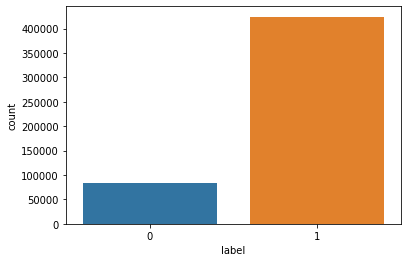

In [56]:
sns.countplot('label', data=df)
plt.show()

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

In [58]:
x = df.drop('label', axis=1, inplace=False)
y = df['label'].values.reshape(-1, 1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100, stratify=y)
print(X_train.shape, X_test.shape)

(355594, 3) (152398, 3)


### Oversampling

In [60]:
smote = SMOTE(random_state=100)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(X_train_over.shape, y_train_over.shape)

(594090, 3) (594090,)


<AxesSubplot:ylabel='count'>

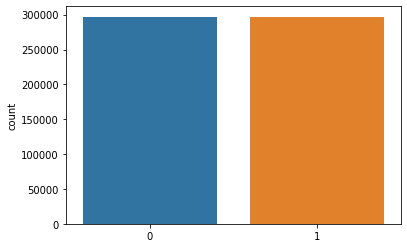

In [61]:
sns.countplot(y_train_over, data=df)

In [62]:
X_train_over

,기온,습도,co2
0,17.200000,37.000000,1720
1,7.500000,71.000000,2693
2,9.300000,45.000000,1671
3,1.200000,66.000000,1318
4,25.000000,48.000000,3179
...,...,...,...
594085,7.350090,57.000000,5536
594086,8.297353,51.003309,5021
594087,17.231537,57.000000,6582
594088,0.804845,55.951552,1811


### Standardization

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_over)
X_test_scaled = scaler.fit_transform(X_test)

In [64]:
scaler_min = MinMaxScaler()
X_train_min_scaled = scaler_min.fit_transform(X_train_over)
X_test_min_scaled = scaler_min.fit_transform(X_test)

In [65]:
print(X_train_scaled.shape, y_train_over.shape)

(594090, 3) (594090,)


### logistic

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [71]:
from sklearn.linear_model import LogisticRegression

# lr_clf = LogisticRegression(solver='liblinear', penalty='elasticnet', C=0.1)
lr_clf = LogisticRegression(solver='liblinear', penalty='l1')
lr_clf.fit(X_train_scaled, y_train_over)
lr_pred = lr_clf.predict(X_test_scaled)
lr_pred_proba = lr_clf.predict_proba(X_test_scaled)[:, 0]

In [72]:
lr_pred_proba

array([0.4486238 , 0.50457404, 0.7317228 , ..., 0.32765141, 0.65757433,
       0.52842524])

In [73]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[16136  8957]
 [59999 67306]]
정확도: 0.5475, 정밀도: 0.8826, 재현율: 0.5287, F1: 0.6613, AUC:0.3671


In [74]:
array2 = np.array([[23, 60, 2000]])
test_scaled2 = scaler.fit(X_train_over).transform(array2)
test_pred2 = lr_clf.predict(test_scaled2)
test_pred_proba2 = lr_clf.predict_proba(test_scaled2)[:, 1]

In [75]:
test_pred_proba2

array([0.58535349])

### minmax

In [84]:
from sklearn.linear_model import LogisticRegression

# lr_clf = LogisticRegression(solver='liblinear', penalty='elasticnet', C=0.1)
lr_clf1 = LogisticRegression(solver='liblinear', penalty='l1')
lr_clf1.fit(X_train_min_scaled, y_train_over)
lr_pred1 = lr_clf1.predict(X_test_min_scaled)
lr_pred_proba1 = lr_clf1.predict_proba(X_test_min_scaled)[:, 0]

In [95]:
array3 = np.array([[20, 50, 4500]])
test_scaled3 = scaler_min.fit(X_train_over).transform(array3)
test_pred3 = lr_clf1.predict(test_scaled3)
test_pred_proba3 = lr_clf1.predict_proba(test_scaled3)[:, 0]

In [96]:
get_clf_eval(y_test, lr_pred1, lr_pred_proba1)

오차 행렬
[[15101  9992]
 [55776 71529]]
정확도: 0.5684, 정밀도: 0.8774, 재현율: 0.5619, F1: 0.6851, AUC:0.3668


In [97]:
print(test_pred3, test_pred_proba3)

[0] [0.58160972]


### lightgbm

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train_scaled, y_train_over)
lgbm_pred = lgbm_clf.predict(X_test_scaled)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test_scaled)[:, 1]

In [37]:
get_clf_eval(y_test, lgbm_pred, lgbm_pred_proba)

오차 행렬
[[ 25092      1]
 [  9920 117385]]
정확도: 0.9349, 정밀도: 1.0000, 재현율: 0.9221, F1: 0.9595, AUC:0.9751


In [42]:
array = np.array([[26, 15, 400]])
test_scaled = scaler.fit(X_train_over).transform(array)

test_pred = lgbm_clf.predict(test_scaled)
test_pred_proba = lgbm_clf.predict_proba(test_scaled)[:, 0]

In [43]:
print(test_pred, test_pred_proba)

[1] [4.88498131e-15]


### minmax

In [37]:
lgbm_clf1 = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf1.fit(X_train_min_scaled, y_train_over)
lgbm_pred1 = lgbm_clf1.predict(X_test_min_scaled)
lgbm_pred_proba1 = lgbm_clf1.predict_proba(X_test_min_scaled)[:, 1]

In [38]:
get_clf_eval(y_test, lgbm_pred1, lgbm_pred_proba1)

오차 행렬
[[ 22526   2567]
 [   457 126848]]
정확도: 0.9802, 정밀도: 0.9802, 재현율: 0.9964, F1: 0.9882, AUC:0.9545


In [97]:
array1 = np.array([[26, 55, 1700]])
test_scaled1 = scaler_min.fit(X_train_over).transform(array1)
test_pred1 = lgbm_clf1.predict(test_scaled1)
test_pred_proba1 = lgbm_clf1.predict_proba(test_scaled1)[:, 0]

In [98]:
print(test_pred1, test_pred_proba1)

[0] [1.]


### Model save

In [22]:
import pickle

In [23]:
saved_model = pickle.dumps(lgbm_clf)
clf_from_pickle = pickle.loads(saved_model)
clf_from_pickle.predict(test_scaled)


array([0], dtype=int64)

In [24]:
import joblib

joblib.dump(lgbm_clf, 'temp_lightgbm.pkl') 

['temp_lightgbm.pkl']

In [27]:
clf_from_joblib = joblib.load('temp_lightgbm.pkl') 
joblib_preb = clf_from_joblib.predict(test_scaled)
joblib_pred_proba = clf_from_joblib.predict_proba(test_scaled)[:, 1]
joblib_pred_proba = joblib_pred_proba 
print(joblib_preb, joblib_pred_proba)

[0] [7.40653616e-12]
